In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

In [2]:
print('Set up config')
country_code = "US"
start_date='01/01/2010'
end_date='06/01/2020'
labels=['loss', 'unemployed', 'search', 'hire', 'offer', 'out_of_work']
features=['statuses_per_day','account_age']
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='../../data'
print('Country:', country_code)
print('End date:', start_date)
print('End date:', end_date)
print('Labels:',', '.join(labels))
print('Features:',', '.join(features))
print(path_to_data)

Set up config
Country: US
End date: 01/01/2010
End date: 06/01/2020
Labels: loss, unemployed, search, hire, offer, out_of_work
Features: statuses_per_day, account_age
../../data


In [3]:
print('Load')
start = timer()
unemployment_rates=pd.read_csv(os.path.join(path_to_data,'official','country','time_series_unemployment_rate.csv'),index_col=0)
user_locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))
users_counts=pq.ParquetDataset(glob(os.path.join(path_to_data,'classification',country_code,'users_counts','*.parquet'))).read().to_pandas()
print("Done in", round(timer()-start), "sec")

Load
Done in 7 sec


In [4]:
print('Prepare unemployment data')
df1=unemployment_rates[country_code].rename('unemployment_rate').reset_index()
df1['unemployment_lag']=df1['unemployment_rate'].shift()
df1['year'] = pd.to_datetime(df1['date']).dt.year
df1['month'] = pd.to_datetime(df1['date']).dt.month
df1.dropna(inplace=True)

Prepare unemployment data


In [5]:
print('Select Twitter data in:', country_code)
df2=users_counts.merge(user_locations.loc[user_locations.country_short==country_code,['user_location']]).drop('user_location',1)
df2.year=df2.year.astype(int)
df2.month=df2.month.astype(int)

Select Twitter data in: US


In [6]:
print('Compute Twitter series by increasing quantile of activity')
start = timer()
df=df1.copy()
for q1 in users_counts['statuses_per_day_quantile'].sort_values().unique():
    for q2 in users_counts['account_age_quantile'].sort_values().unique():
        name='statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))
        tmp=df2[(df2['statuses_per_day_quantile']>=q1)&(df2['account_age_quantile']>=q2)].drop([
        'statuses_per_day_quantile','account_age_quantile'],1)
        tmp=tmp.groupby(['year','month'],as_index=False).sum()
        tmp[labels]=tmp[labels].divide(tmp['user_id'],0)
        tmp.rename(columns=lambda x:x+'_'+name if x in labels+['user_id'] else x,inplace=True)
        df=df.merge(tmp,how='left')
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
print("Done in", round(timer()-start), "sec")

Compute Twitter series by increasing quantile of activity
Done in 88 sec


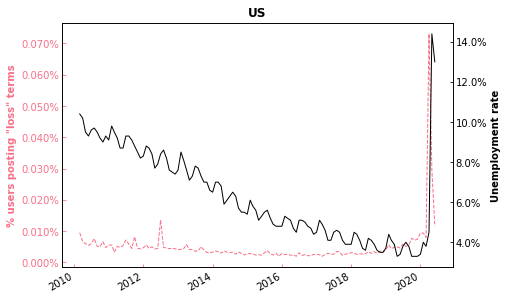

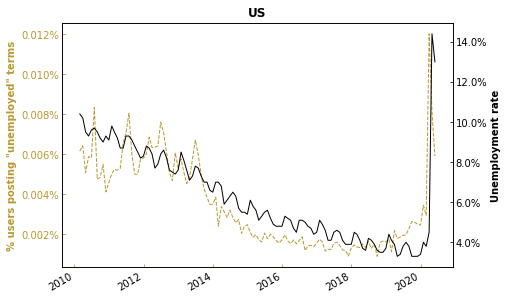

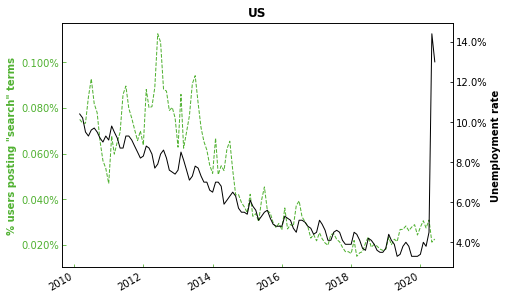

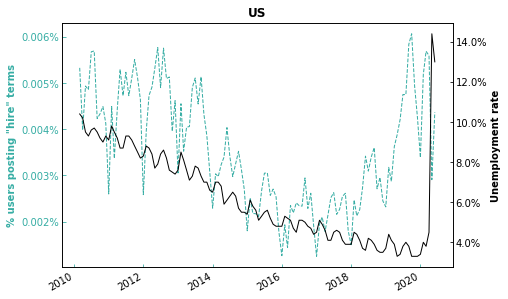

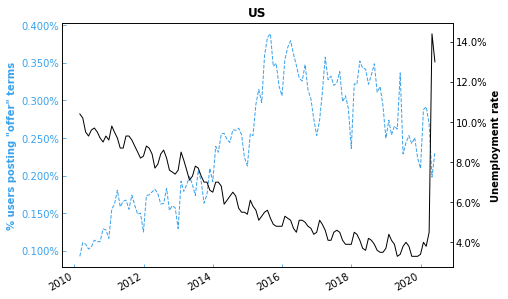

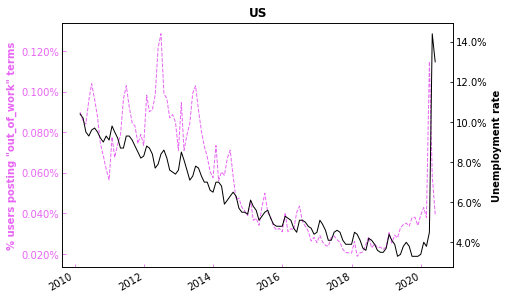

In [7]:
def plot_twitter_data_versus_unemployment_rate(q1,q2):
    for i,label in enumerate(labels):
        colors = sns.color_palette("husl", 12)
        fig,ax1=plt.subplots(figsize=(7,5))
        ax2 = ax1.twinx()
        ax1.plot(df['date'],df[label+'_statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))],linewidth=1,color=colors[2*i],linestyle='dashed')
        ax2.plot(df['date'],df['unemployment_rate'],linewidth=1,color='k')
        ax1.tick_params(which='both',direction='in',pad=3,color=colors[2*i])
        ax2.tick_params(which='both',direction='in',pad=3,color='k')
        ax1.locator_params(axis='y',nbins=8)
        ax2.locator_params(axis='y',nbins=8)
        ax1.set_xlabel('')
        ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
        ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
        ax1.set_ylabel('% users posting "'+label+'" terms',fontweight='bold',color=colors[2*i])
        ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
        ax1.set_title(country_code,fontweight='bold')
        fig.autofmt_xdate()
        plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+label+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')
    
for q1 in users_counts['statuses_per_day_quantile'].sort_values().unique()[:1]:
    for q2 in users_counts['account_age_quantile'].sort_values().unique()[:1]:
        plot_twitter_data_versus_unemployment_rate(q1,q2)

In [8]:
print('In-sample regressions')
def regression_by_users_group(q1,q2):
    group='_statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))
    exogs=[['unemployment_lag']]
    for label in sorted(labels):
        exogs.extend([[label],['unemployment_lag',label]])
    models=[]
    for exog in exogs:
        tmp=pd.concat([df.filter(regex='unemployment'),df.filter(regex=group).copy()],1).dropna()
        tmp.rename(columns=lambda x:x.replace(group,''),inplace=True)
        models.append(sm.OLS(endog=tmp['unemployment_rate'],exog=sm.add_constant(tmp[exog])).fit())
    stargazer = Stargazer(models)
    stargazer.dependent_variable_name('Unemployment rate')
    return HTML(stargazer.render_html())

regression_by_users_group(0,0)

In-sample regressions


Out-of-sample Forecasting
Predictions
RMSE


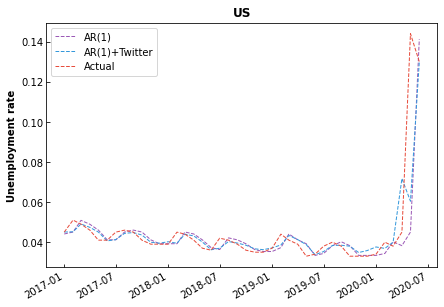

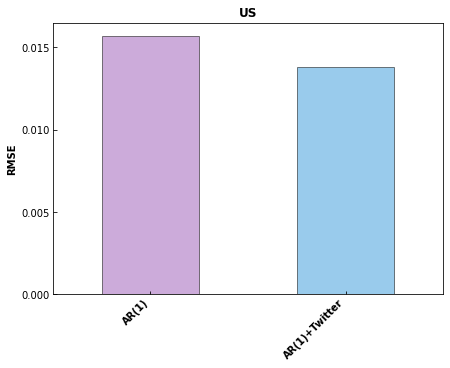

In [9]:
print('Out-of-sample Forecasting')
date_split='31/12/2016'
q1,q2=0,0
group='_statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))
exogs=[['unemployment_lag'],labels+['unemployment_lag']]
names=['AR(1)','AR(1)+Twitter']
rmse=[]
y_predict={}
colors=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for (name,exog) in zip(names, exogs):
    
    tmp=pd.concat([df['date'],df.filter(regex='unemployment'),df.filter(regex=group).copy()],1)
    tmp.rename(columns=lambda x:x.replace(group,''),inplace=True)
    train=tmp[tmp['date']<=pd.to_datetime(date_split)].copy()
    test=tmp[tmp['date']>=pd.to_datetime(date_split)].copy()
    model=sm.OLS(endog=train['unemployment_rate'],exog=sm.add_constant(train[exog])).fit()
    y_predict[name]=sm.add_constant(test[exog]).multiply(model.params).sum(1)
    rmse.append((name,np.sqrt(np.mean((test['unemployment_rate']-y_predict[name])**2))))
    
#####################################################################################################################

print('Predictions')
fig,ax=plt.subplots(figsize=(7,5))
for i,name in enumerate(names):
    plt.plot(test['date'],y_predict[name],color=colors[i],linestyle='dashed',linewidth=1,label=name)
# plt.plot(train['date'],train['unemployment_rate'],color=colors[2],linewidth=1)
plt.plot(test['date'],test['unemployment_rate'],color=colors[3],linestyle='dashed',linewidth=1,label='Actual')
ax.tick_params(which='both',direction='in',pad=3)
plt.legend(loc='best')
ax.set_title(country_code,fontweight='bold')
ax.set_ylabel('Unemployment rate',fontweight='bold',color='k')
fig.autofmt_xdate()
plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+'-predictions'+'-'.join(labels)+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')

#####################################################################################################################

print('RMSE')
fig,ax=plt.subplots(figsize=(7,5))
pd.DataFrame(rmse,columns=['model','RMSE']).set_index('model')['RMSE'].plot(
ax=ax,
kind='bar',
width=.5,    
legend=False, 
stacked=True, 
color=colors,
alpha=0.5,
edgecolor='k')
ax.set_xlabel('')
ax.set_ylabel('RMSE',fontweight='bold',color='k')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right',fontweight='bold')
ax.locator_params(axis='y',nbins=5)
ax.set_title(country_code,fontweight='bold')
plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+'-rmse'+'-'.join(labels)+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')